In [272]:
from matplotlib import gridspec, cm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import pickle
import skimage.io
from skimage.feature import hog
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA,KernelPCA, SparsePCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from PIL import Image

import statsmodels.api as sm
from scipy.stats import shapiro, kstest, normaltest, anderson

In [273]:
#TODO module docstring, examples for functions

class CustomLabelEncoder:
    """
    Creates a mapping between string labels and integer class clabels for working with categorical data.
    
    
    Attributes
    ----------
    mapper:None dict
        None if mapper is not supplied or model is not fit.
        keys are unique string labels, values are integer class labels.
    """
    def __init__(self, mapper=None):
        """
        Initializes class instance.
        
        If the mapper dictionary is supplied here, then the model can be used without calling .fit().
        
        Parameters
        -----------
        mapper (optional): dict or None
            if mapper is None encoder will need to be fit to data before it can be used.
            If it is a dictionary mapping string labels to integer class labels, then this will be stored
            and the model can be used to transform data.
        """
        self.mapper = mapper
    
    def fit(self, str_labels, sorter=None):
        """
        Fits string labels to intiger indices with optional sorting.
        
        np.unique() is used to extract the unique values form labels. If 
        
        Parameters
        ----------
        str_labels: list-like
            list or array containing string labels
        
        sorter (optional): None or function
            key for calling sorted() on data to determine ordering of the numeric indices for each label.
            
        Attributes
        -----------
        mapper: dict
            dictionary mapping string labels to the sorted integer indices is stored after fitting.
        
        """
        sorted_unique = sorted(np.unique(str_labels), key=sorter)
        mapper = {label: i for i, label in enumerate(sorted_unique)}
        self.mapper = mapper    

    def transform(self, str_labels):
        """
        Maps string labels to integer labels.
        
        Parameters
        ----------
        str_labels: list-like
            list of string labels whose elements are in self.mapper
        
        Returns
        --------
        int_labels: array
            array of integer labels  corresponding to the string labels
        """
        assert self.mapper is not None, 'Encoder not fit yet!'
        
        int_labels = np.asarray([self.mapper[x] for x in str_labels], np.int)
        
        return int_labels
        
    def inverse_transform(self, int_labels):
        """
        Maps integer labels to original string labels.
        
        Parameters
        -----------
        int_labels: list-like
            list or array of integer class indices
        
        Returns
        ----------
        str_labels: array(str)
            array of string labels corresponding to intiger indices
        
        """
        assert self.mapper is not None, 'Encoder not fit yet!'
        
        reverse_mapper = {y:x for x,y in self.mapper.items()}
        
        str_labels = np.asarray([reverse_mapper[x] for x in int_labels])
        
        return str_labels
    
    @property
    def labels_ordered(self):
        """
        Returns an array containing the string labels in order of which they are stored.
        
        For example, if the label_encoder has the following encoding: {'a':1,'c':3,'b':2},
        then this will return array(['a','b','c'])
        """
        pass
    
    @labels_ordered.getter
    def labels_ordered(self):
        return self.inverse_transform(range(len(self.mapper)))

def label_matcher(y_cluster, labels, return_mapper=False):
    """
    maps cluster centers to true labels based on the most common filename for each cluster. 
    Parameters
    ----------
    y_cluster: ndarray
        n-element array of labels obtained from clusters
        
    labels: ndarray
        n-element array of ground truth labels for which y_cluster will be mapped to
        
    return_mapper:bool
        if True, dictionary mapping values in y_cluster to values in labels will be returned
    Returns
    -----------
    y_pred: ndarray
        n-element array of values in y_cluster mapped to labels
    
    mapper (optional): dict
        dictonary whose keys are elements of y_cluster and values are the corresponding
        elements of labels.
    """
        
    y_cluster = np.asarray(y_cluster)
    labels = np.asarray(labels)
    
    y_cluster_unique = np.unique(y_cluster)

    
    mapper = {}  # keys will be cluster ID's, values will be corresponding label
    
    for x in y_cluster_unique:
        unique, counts = np.unique(labels[y_cluster==x], return_counts=True)  # get frequency of each gt label in cluster x
        mapper[x] = unique[counts.argmax()]  # set mapper[x] to the most frequent label in the cluster

    y_pred = np.asarray([mapper[x] for x in y_cluster])  # map cluster id's to labels

    if return_mapper:
        return y_pred, mapper
    else:
        return y_pred

def pretty_cm(cm, labelnames, cscale=0.6, ax0=None, fs=6, cmap='cool'):
    """
    Generates a pretty-formated confusion matrix for convenient visualization.
    
    The true labels are displayed on the rows, and the predicted labels are displayed on the columns.
    
    Parameters
    ----------
    cm: ndarray 
        nxn array containing the data of the confusion matrix.
    
    labelnames: list(string)
        list of class names in order on which they appear in the confusion matrix. For example, the first
        element should contain the class corresponding to the first row and column of *cm*.
    cscale: float
        parameter that adjusts the color intensity. Allows color to be present for confusion matrices with few mistakes,
        and controlling the intensity for ones with many misclassifications.
    
    ax0: None or matplotlib axis object
        if None, a new figure and axis will be created and the visualization will be displayed.
        if an axis is supplied, the confusion matrix will be plotted on the axis in place.
    fs: int
        font size for text on confusion matrix.
        
    cmap: str
        matplotlib colormap to use
    
    Returns
    ---------
    None
    
    """
    
    acc = cm.trace() / cm.sum()
    if ax0 is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 2.5), dpi=300)
        fig.set_facecolor('w')
    else:
        ax = ax0

    n = len(labelnames)
    ax.imshow(np.power(cm, cscale), cmap=cmap, extent=(0, n, 0, n))
    labelticks = np.arange(n) + 0.5
    
    ax.set_xticks(labelticks, minor=True)
    ax.set_yticks(labelticks, minor=True)
    ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
    ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)
    
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels=labelnames, minor=True, fontsize=fs)
    ax.set_yticklabels(labels=reversed(labelnames), minor=True, fontsize=fs)

    ax.set_xlabel('Predicted Labels', fontsize=fs)
    ax.set_ylabel('Actual Labels', fontsize=fs)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j + 0.5, n - i - 0.5, '{:^5}'.format(z), ha='center', va='center', fontsize=fs,
                bbox=dict(boxstyle='round', facecolor='w', edgecolor='0.3'))
    ax.grid(which='major', color=np.ones(3) * 0.33, linewidth=1)

    if ax0 is None:
        ax.set_title('Accuracy: {:.3f}'.format(cm.trace() / cm.sum()), fontsize=fs+2)
        plt.show()
        return
    else:
        return ax


#### Load data

In [274]:
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std_224.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224.pickle')
fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224_normalized.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224_non_normalized.pickle')
assert fc1_path.is_file()

le_path = Path('/home/richard/data/Schiefer/features/label_encoder.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)
    
with open(le_path, 'rb') as l:
    le = pickle.load(l)

In [275]:
files = data['filename']
fc1 = data['features']
labels = data['labels']
y_gt = le.transform(labels)

/tmp/ipykernel_307719/2096747715.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_labels = np.asarray([self.mapper[x] for x in str_labels], np.int)


In [276]:
print(type(fc1[0]))
print(fc1.shape)

<class 'numpy.ndarray'>
(291, 2048)


#### Dimension reduction
#### PCA

- PCA reduce dimensionality and filter out noise in the data
- How many dimensions to keep?
- No clear answer, but keep components that contain **signal** (significant variance) and **get rid of ones** that are mostly noise
  - A: rule of thumb for high dimensional data is to select 50 components
  - inspect how much variance each component preserves before selecting 50
  - B: or directly aim for an automated process to determine the amount of components

#### Simple PCA

#### A

variance preserved by 50 components: 0.892


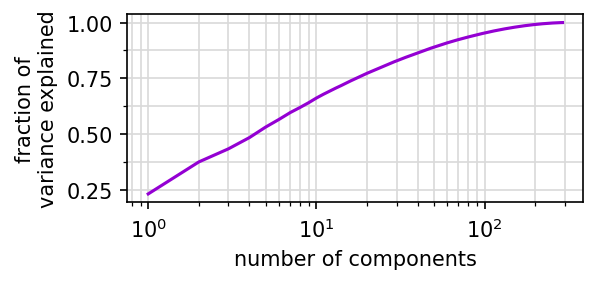

In [277]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1) # apply reduction on x

var_ = pca_n.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var_)+1), var_, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)

fig.tight_layout()
#fig.savefig(Path('..','Figures','PCA_Var.png'), bbox_inches='tight')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))


0.8066778


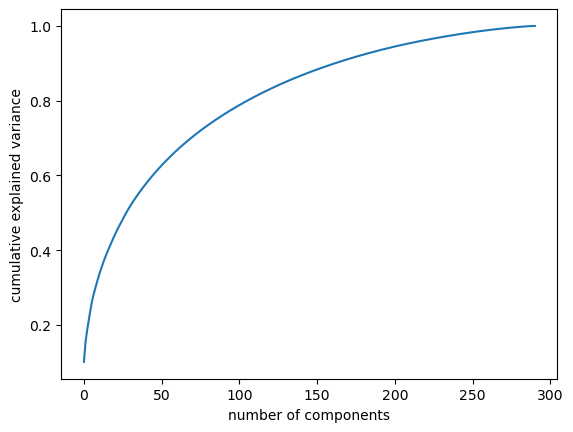

In [278]:
scaler = StandardScaler().set_output(transform="pandas")
rescaled = scaler.fit_transform(fc1)
pca = PCA().fit(rescaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print()
var_ = pca.explained_variance_ratio_.cumsum()
print(var_[108])

#### B Min-Max [0,1] Scaler

In [279]:
# # select pca data and determine number of components in an automatic fashion
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# pca.fit(data_rescaled)
# reduced = pca.fit_transform(data_rescaled)
# print(reduced.shape)

#### B1 z Score Scaler

In [280]:
# standardize values with z-score more effective than min-max and decimal scaling!
# removing mean and scaling to unit variance
# mean of 0 and standard deviation of 1, unlike min-max it does not rescale the feature to a fixed range
scaler = StandardScaler().set_output(transform="pandas")
rescaled = scaler.fit_transform(fc1)
#reduced = rescaled

scaled_pca = PCA(n_components=0.80) # higher values may introduce overfitting of the model
scaled_pca.fit(rescaled)
reduced = scaled_pca.fit_transform(rescaled)
print(reduced.shape)

(291, 107)


#### Kernel PCA

In [281]:
# scaler = MinMaxScaler()
# data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# kernel_pca = KernelPCA(
#     n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
# )

# X_test_kernel_pca = kernel_pca.fit(data_rescaled).fit_transform(data_rescaled)
# print(X_test_kernel_pca.shape)
# reduced = X_test_kernel_pca

#### Sparse PCA

In [282]:
# scaler = StandardScaler().set_output(transform="pandas")
# rescaled = scaler.fit_transform(fc1)

# sparse_PCA = SparsePCA(n_components=100, random_state=25)
# sparse_PCA.fit(rescaled)
# reduced = sparse_PCA.fit_transform(rescaled)
# print(reduced.shape)

#### Randomized PCA

In [283]:
# scaler = StandardScaler().set_output(transform="pandas")
# rescaled = scaler.fit_transform(fc1)
# #reduced = rescaled

# scaled_pca = PCA(n_components=108, svd_solver='randomized', random_state=27) # higher values may introduce overfitting of the model
# scaled_pca.fit(rescaled)
# reduced = scaled_pca.fit_transform(rescaled)
# print(reduced.shape)

#### Determine the optimal number of clusters k

#### A: Elbow Method

1 : 36.23005504877996
2 : 34.29190667282614
3 : 33.77121768757869
4 : 33.07413458580274
5 : 32.76984790627588
6 : 32.282707201582284
7 : 31.992067148543587
8 : 31.676442349418235
9 : 31.438482012404688


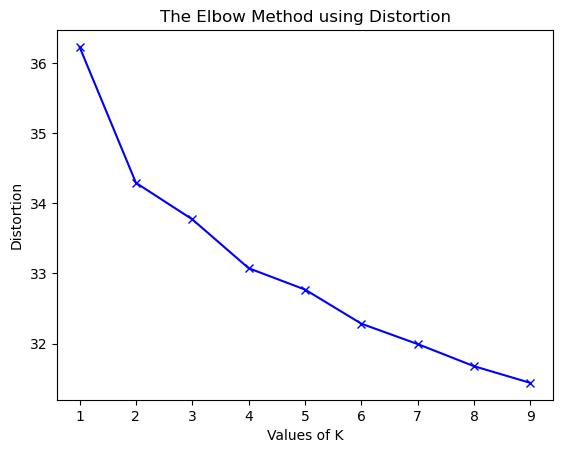

In [284]:
# determine optimal number of k -> we know from Schiefer labels that this image contains 4 classes
# with elbow method
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_init=10,n_clusters=k).fit(reduced)
    kmeanModel.fit(reduced)
  
    distortions.append(sum(np.min(cdist(reduced, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / reduced.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(reduced, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / reduced.shape[0]
    mapping2[k] = kmeanModel.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#### B: Scaled Insertia Method

In [285]:
# # scaled inertia approach to determine optimal k
# def kMeansRes(scaled_data, k, alpha_k=0.02):
#     '''
#     Parameters 
#     ----------
#     scaled_data: matrix 
#         scaled data. rows are samples and columns are features for clustering
#     k: int
#         current k for applying KMeans
#     alpha_k: float
#         manually tuned factor that gives penalty to the number of clusters
#     Returns 
#     -------
#     scaled_inertia: float
#         scaled inertia value for current k           
#     '''
    
#     inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
#     # fit k-means
#     kmeans = KMeans(n_init=500,n_clusters=k, random_state=0).fit(scaled_data)
#     scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
#     return scaled_inertia

# def chooseBestKforKMeansParallel(scaled_data, k_range):
#     '''
#     Parameters 
#     ----------
#     scaled_data: matrix 
#         scaled data. rows are samples and columns are features for clustering
#     k_range: list of integers
#         k range for applying KMeans
#     Returns 
#     -------
#     best_k: int
#         chosen value of k out of the given k range.
#         chosen k is k with the minimum scaled inertia value.
#     results: pandas DataFrame
#         adjusted inertia value for each k in k_range
#     '''
    
#     ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(scaled_data, k) for k in k_range)
#     ans = list(zip(k_range,ans))
#     results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
#     best_k = results.idxmin()[0]
#     return best_k, results

# def chooseBestKforKMeans(scaled_data, k_range):
#     ans = []
#     for k in k_range:
#         scaled_inertia = kMeansRes(scaled_data, k)
#         ans.append((k, scaled_inertia))
#     results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
#     best_k = results.idxmin()[0]
#     return best_k, results

# # choose k range
# k_range=range(2,20)
# # compute adjusted intertia
# best_k, results = chooseBestKforKMeansParallel(reduced, k_range)
# print("best k is",best_k)

# # plot the results
# plt.figure(figsize=(7,4))
# plt.plot(results,'o')
# plt.title('Adjusted Inertia for each K')
# plt.xlabel('K')
# plt.ylabel('Adjusted Inertia')
# plt.xticks(range(2,20,1))

In [286]:
scaler = StandardScaler().set_output(transform="pandas")
rescaled = scaler.fit_transform(fc1)
# no whitening
pca_nw = PCA(n_components=0.80, svd_solver='full', whiten=False)
x_nw = pca_nw.fit_transform(rescaled)
tsne = TSNE(n_components=2, random_state=12214)
x_nw_tsne = tsne.fit_transform(x_nw)
#with withening
pca = PCA(n_components=50, svd_solver='full', whiten=True)
x = pca.fit_transform(rescaled)
tsne_w = TSNE(n_components=2, random_state=654753)
x_w_tsne = tsne_w.fit_transform(x)

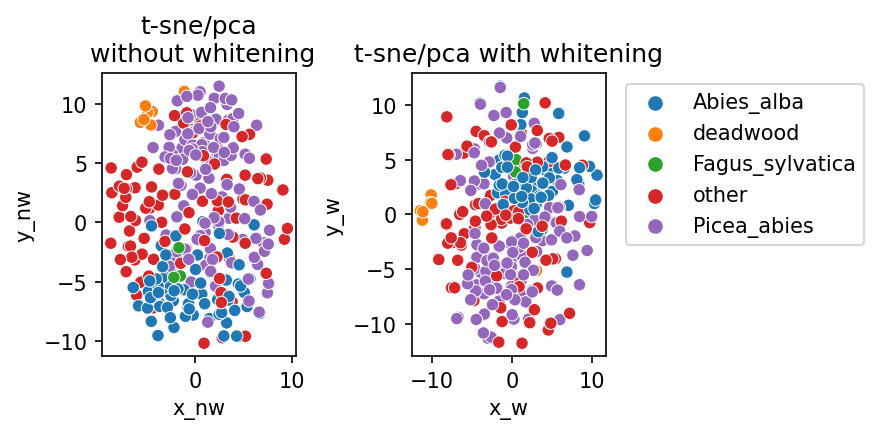

In [287]:
labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
fig.tight_layout()
plt.show()

In [288]:
# labels_ordered = le.inverse_transform(range(len(le.mapper)))
# df = pd.DataFrame({'files': files,
#                    'x_nw':x_nw_tsne[:,0],
#                    'y_nw':x_nw_tsne[:,1],
#                    'labels': labels,
#                   },
#                   index=files)

# fig, ax = plt.subplots(1, figsize=(6,3), dpi=150)
# sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered)
# ax.legend(bbox_to_anchor=(1.05,1))
# ax.set_title('t-sne/pca\n without whitening')
# fig.tight_layout()
# plt.show()

#### Applying K-Means

In [289]:
# alt clustering
# # initialize model
model = KMeans(n_clusters=5, init='k-means++', n_init=500, random_state=42)
#fit data into the model
model.fit(reduced)
# extract labels
labels_unmatched = model.labels_
y_pred = label_matcher(labels_unmatched, y_gt)
print('inertia: {:.2f}'.format(model.inertia_))

inertia: 395471.66


#### Applying K-medoids

In [290]:
# kmedoids = KMedoids(n_clusters=5, random_state=42)
# kmedoids.fit(reduced)
# labels_unmatched = kmedoids.labels_
# y_pred = label_matcher(labels_unmatched, y_gt)
# print('inertia: {:.2f}'.format(kmedoids.inertia_))

#### Applying DBSCAN

In [291]:
# dbscan = DBSCAN(eps=3, min_samples=5).fit(rescaled)
# labels_unmatched = dbscan.labels_
# y_pred = label_matcher(labels_unmatched, y_gt)
# #print('inertia: {:.2f}'.format(dbscan.inertia_))

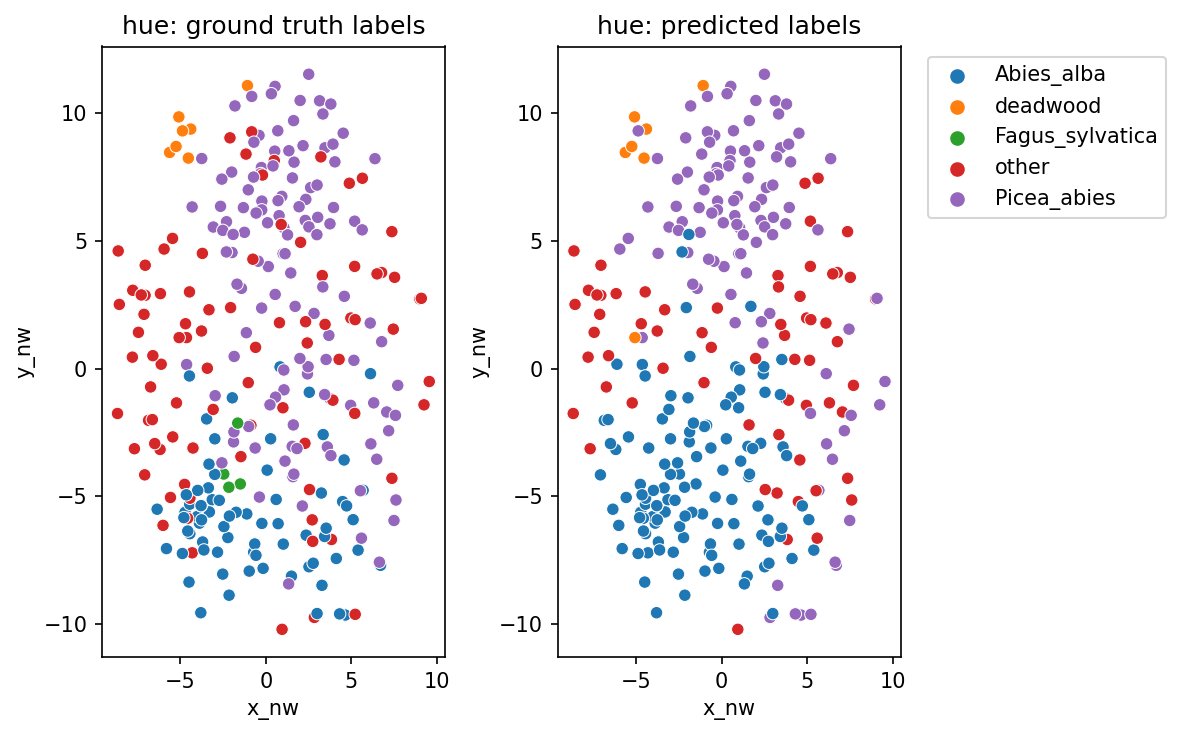

In [292]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

/tmp/ipykernel_307719/2096747715.py:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
/tmp/ipykernel_307719/2096747715.py:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


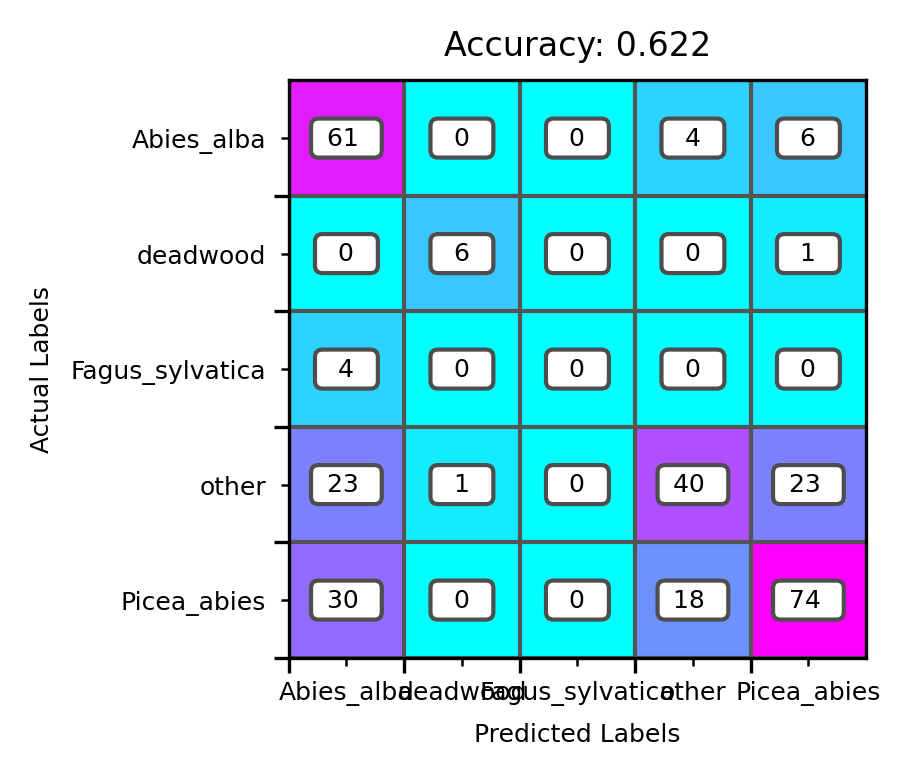

Accuracy: 0.622


In [293]:
# confusion matrix
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

In [294]:
# f1-score
from sklearn.metrics import f1_score
print(f1_score(y_gt, y_pred, average='macro'))
print(f1_score(y_gt, y_pred, average='micro'))
print(f1_score(y_gt, y_pred, average='weighted'))

0.5388851021921045
0.6219931271477663
0.6131817956577164


[0 1 2 3 4]


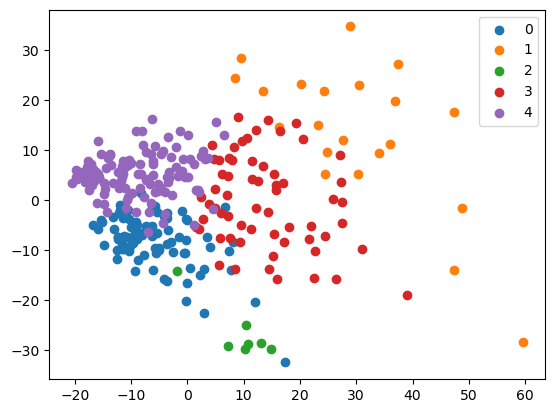

In [295]:
# plot all labels
labels = labels_unmatched
u_labels = np.unique(labels)
print(u_labels)

for i in u_labels:
    plt.scatter(reduced[labels == i , 0] , reduced[labels == i , 1] , label = i)
plt.legend()
plt.show()

#### Apply KMeans

In [296]:
# # initialize model
model = KMeans(n_clusters=best_k, init='k-means++', n_init=500, random_state=42)

#fit data into the model
model.fit(reduced)

# extract labels
labels = model.labels_

print('inertia: {:.2f}'.format(model.inertia_))

inertia: 395471.66


In [297]:
# make df, optional
df = pd.DataFrame(columns=['filename','label'])
df['filename'] = files
df['label'] = labels


#df.sort_values(by=['label'],inplace=True)
df.head(25)
#df.to_csv('/home/richard/data/Schiefer/clustering_results.csv')
# TODO: Include values from clustering alg

,filename,label
0,/home/richard/data/Schiefer/preprocessedwithpi...,0
1,/home/richard/data/Schiefer/preprocessedwithpi...,3
2,/home/richard/data/Schiefer/preprocessedwithpi...,4
3,/home/richard/data/Schiefer/preprocessedwithpi...,0
4,/home/richard/data/Schiefer/preprocessedwithpi...,4
5,/home/richard/data/Schiefer/preprocessedwithpi...,4
6,/home/richard/data/Schiefer/preprocessedwithpi...,4
7,/home/richard/data/Schiefer/preprocessedwithpi...,0
8,/home/richard/data/Schiefer/preprocessedwithpi...,4
9,/home/richard/data/Schiefer/preprocessedwithpi...,4


#### Visualization of results

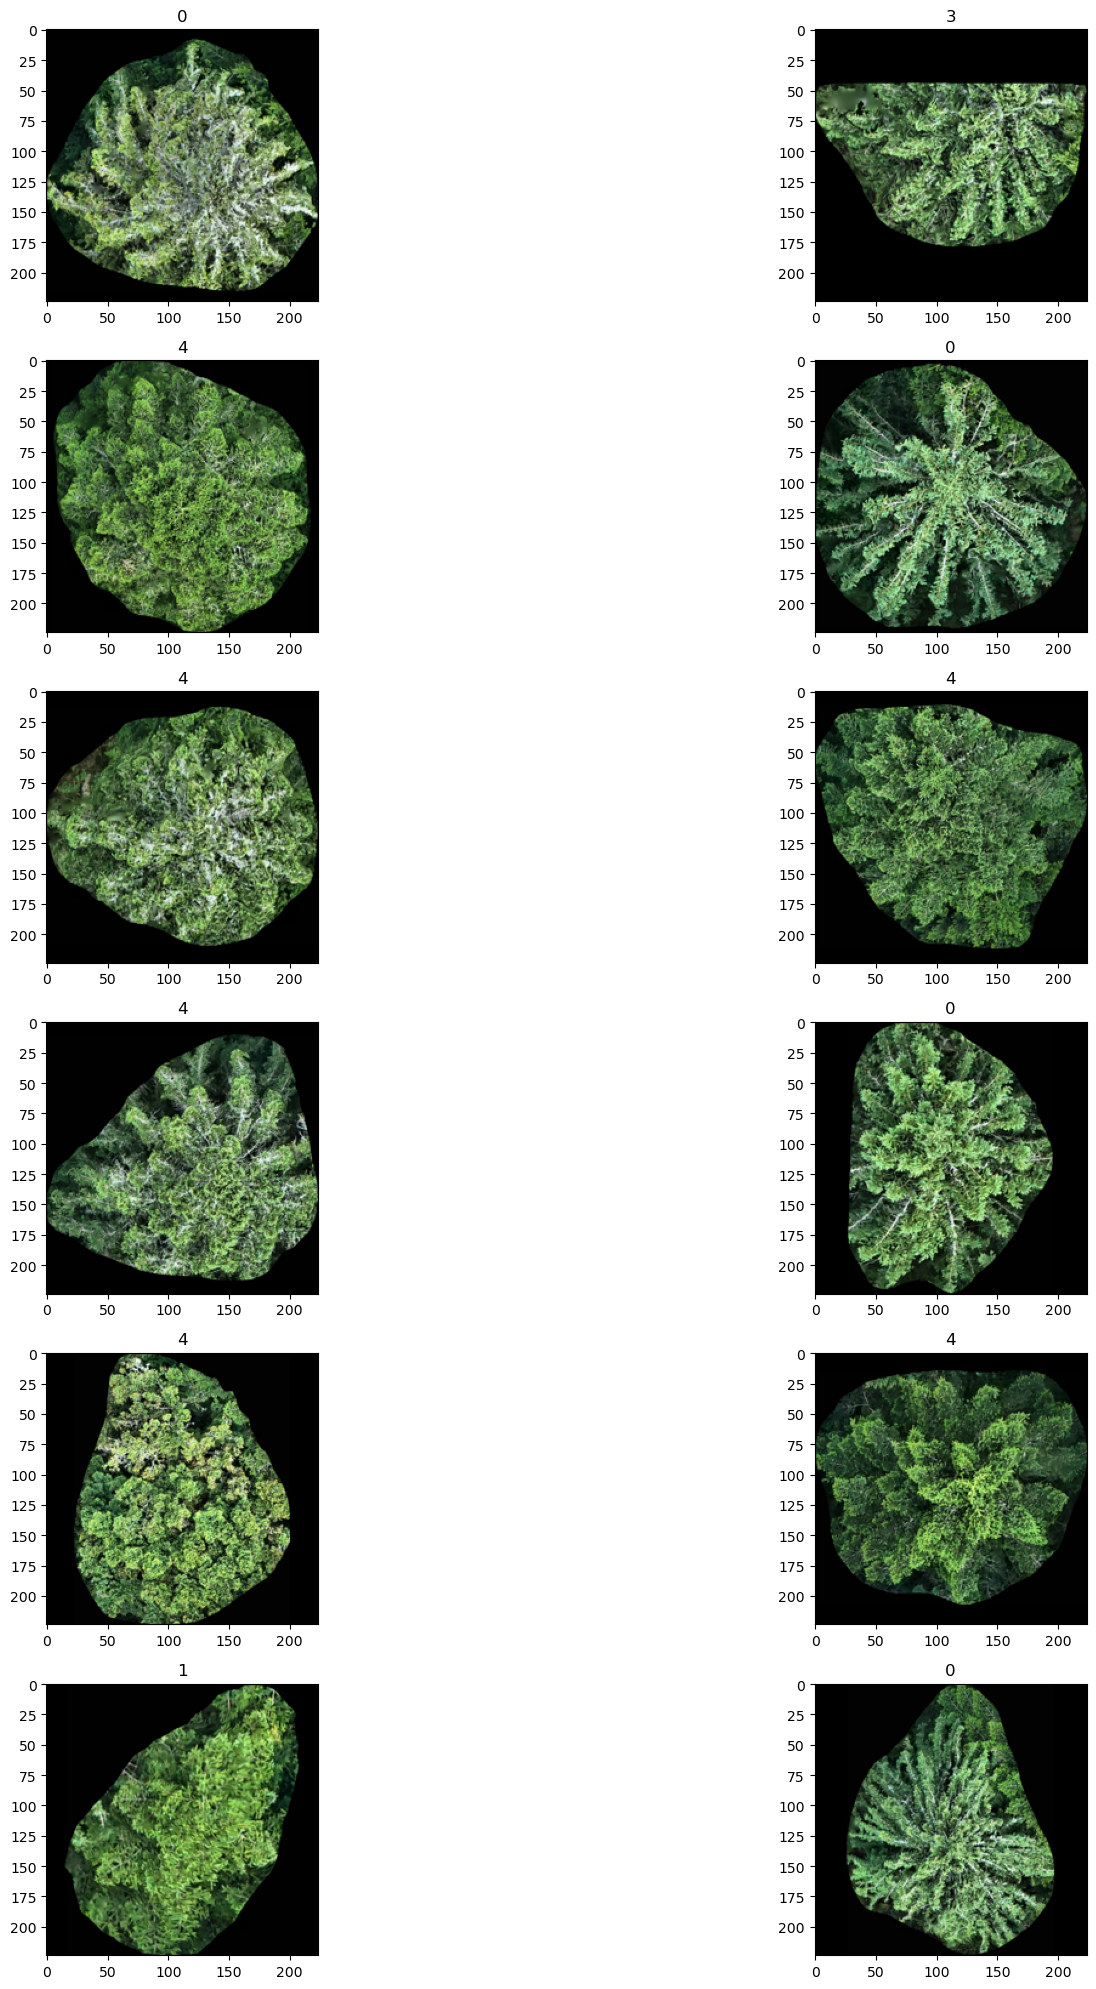

In [298]:
n_row = 6
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(20, 20))
axs = axs.flatten()
imgs = df['filename']
for img_path, ax in zip(imgs[0:n_row*n_col], axs):
    img = Image.open(img_path)
    label_value = df.loc[df.filename == img_path, 'label'].values[0]
    ax.set_title(label_value)
    ax.imshow(img)
plt.tight_layout()
plt.show()

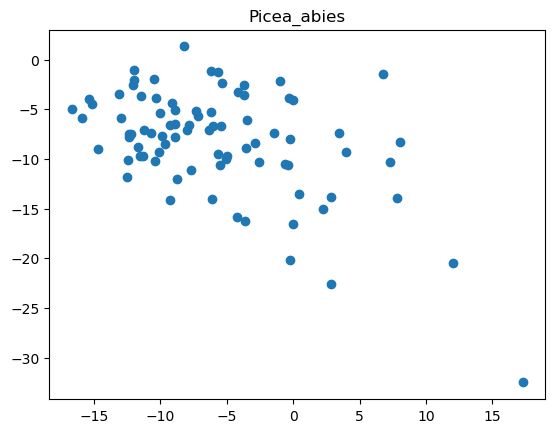

In [299]:
# plot label 0 k means cluster
filtered_labels0 = reduced[labels == 0]
plt.title(y_pred_str[0])
plt.scatter(filtered_labels0[:,0] , filtered_labels0[:,1])
plt.show()

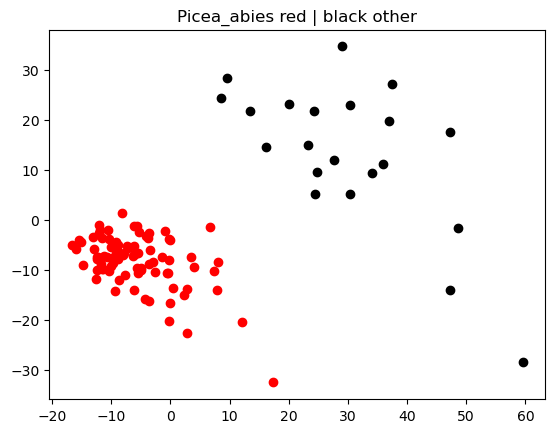

In [300]:
#filter rows of original data
filtered_label2 = reduced[labels == 0]
 
filtered_label8 = reduced[labels == 1]
 
#Plotting the results
plt.title(y_pred_str[0] + " red | black " +  y_pred_str[1])
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.show()

[0 1 2 3 4]


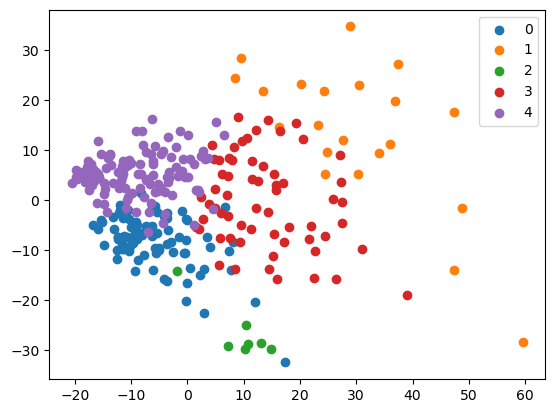

In [301]:
# plot all labels
u_labels = np.unique(labels)
print(u_labels)

for i in u_labels:
    plt.scatter(reduced[labels == i , 0] , reduced[labels == i , 1] , label = i)
plt.legend()
plt.show()


#### T-SNE Visulization

T-SNE maps components in high-dimensional space to lower dimensions. Used to project data to 2d for visulization. Technique preserve pairwise distances for points.

In [302]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1

# tsne
pca_nw = PCA(n_components=0.95, svd_solver='full', whiten=False)
x_nw = pca_nw.fit_transform(data_rescaled)

tsne = TSNE(n_components=2, random_state=12214) # reducing dimension to two
x_nw_tsne = tsne.fit_transform(x_nw)

# scale coordinates to fit 0:1
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = x_nw_tsne[:, 0]
ty = x_nw_tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

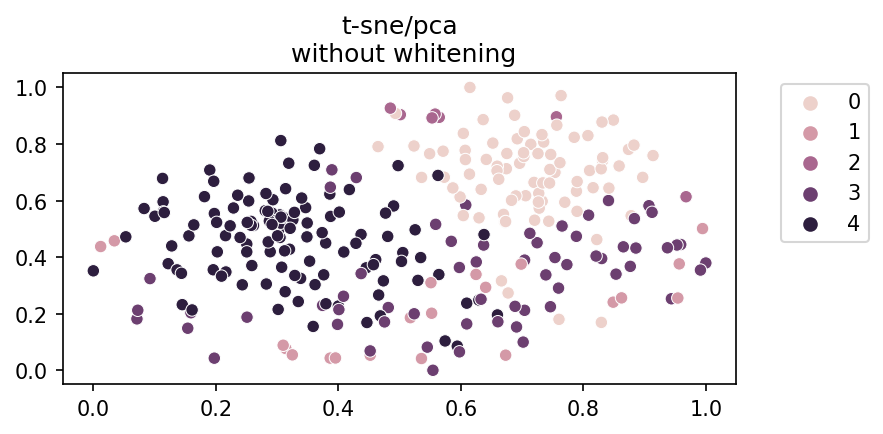

In [303]:
df = pd.DataFrame({'files': files,
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x=tx, y=ty, hue='labels')
ax.legend(bbox_to_anchor=(1.05,1))
ax.set_title('t-sne/pca\n without whitening')
fig.tight_layout()
plt.show()

In [304]:
# # spectral clustering --> bad results
# import sklearn.datasets as skl_data
# import sklearn.cluster as skl_cluster

# graph_model = skl_cluster.SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans')

# scaler = MinMaxScaler()
# gr = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
# pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
# pca.fit(gr)
# graph = pca.fit_transform(gr)

# graph_labels = model.fit_predict(graph)

# plt.scatter(fc1[:, 0], fc1[:, 1], s=15, linewidth=0, c=labels, cmap='flag')
# plt.show()

#### Cluster Analysis

For n_clusters = 2 The average silhouette_score is : 0.18655488
For n_clusters = 3 The average silhouette_score is : 0.18902898
For n_clusters = 4 The average silhouette_score is : 0.17440814
For n_clusters = 5 The average silhouette_score is : 0.16944177
For n_clusters = 6 The average silhouette_score is : 0.041065175


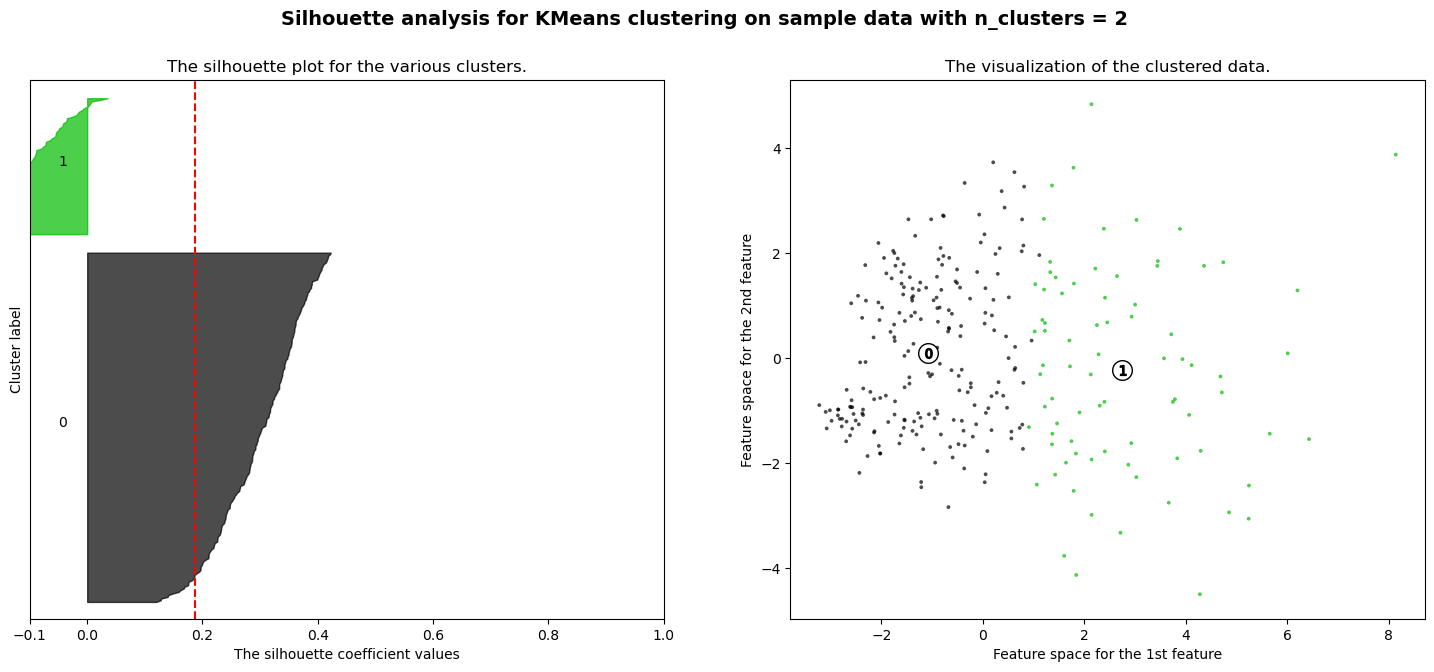

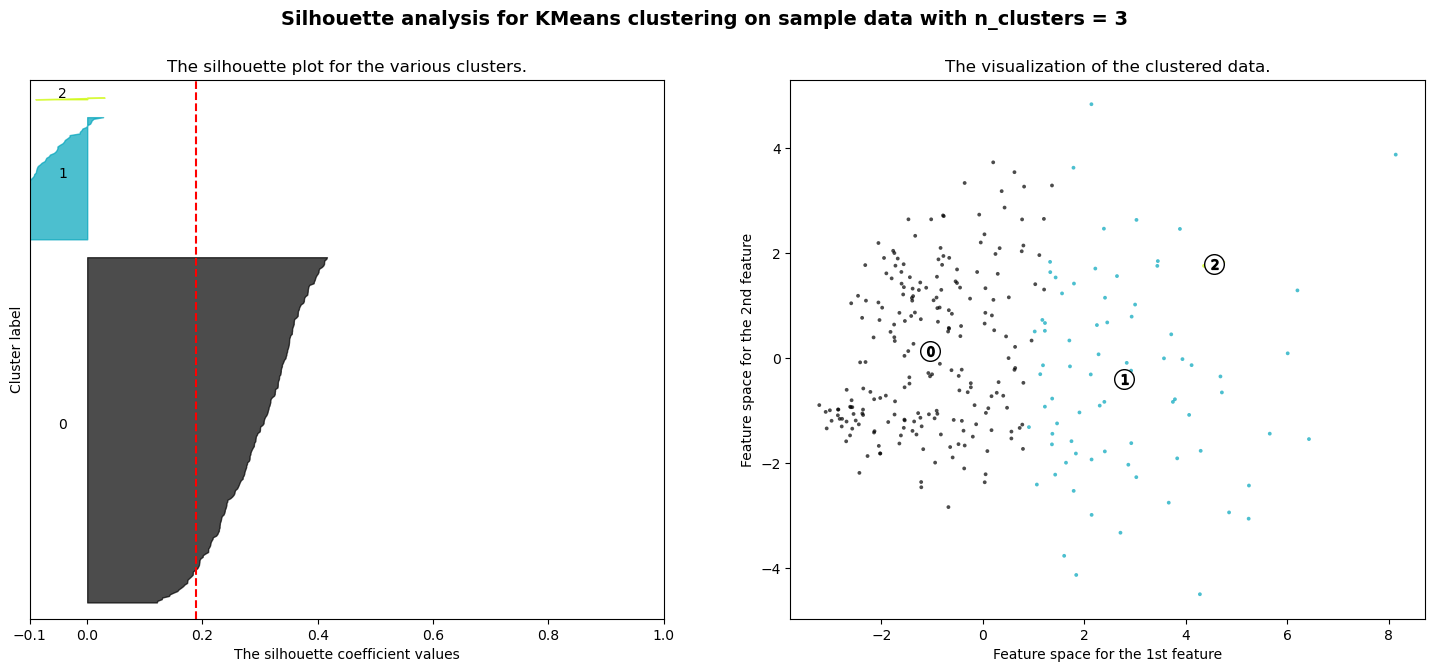

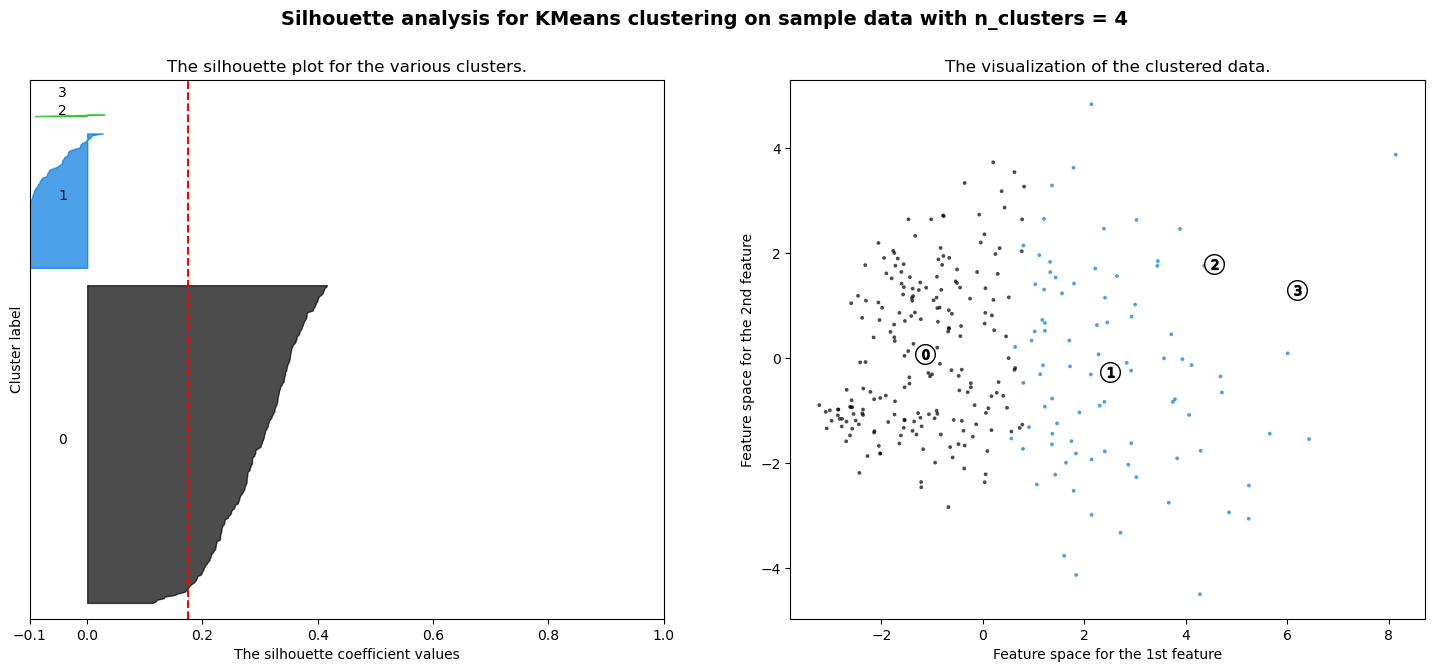

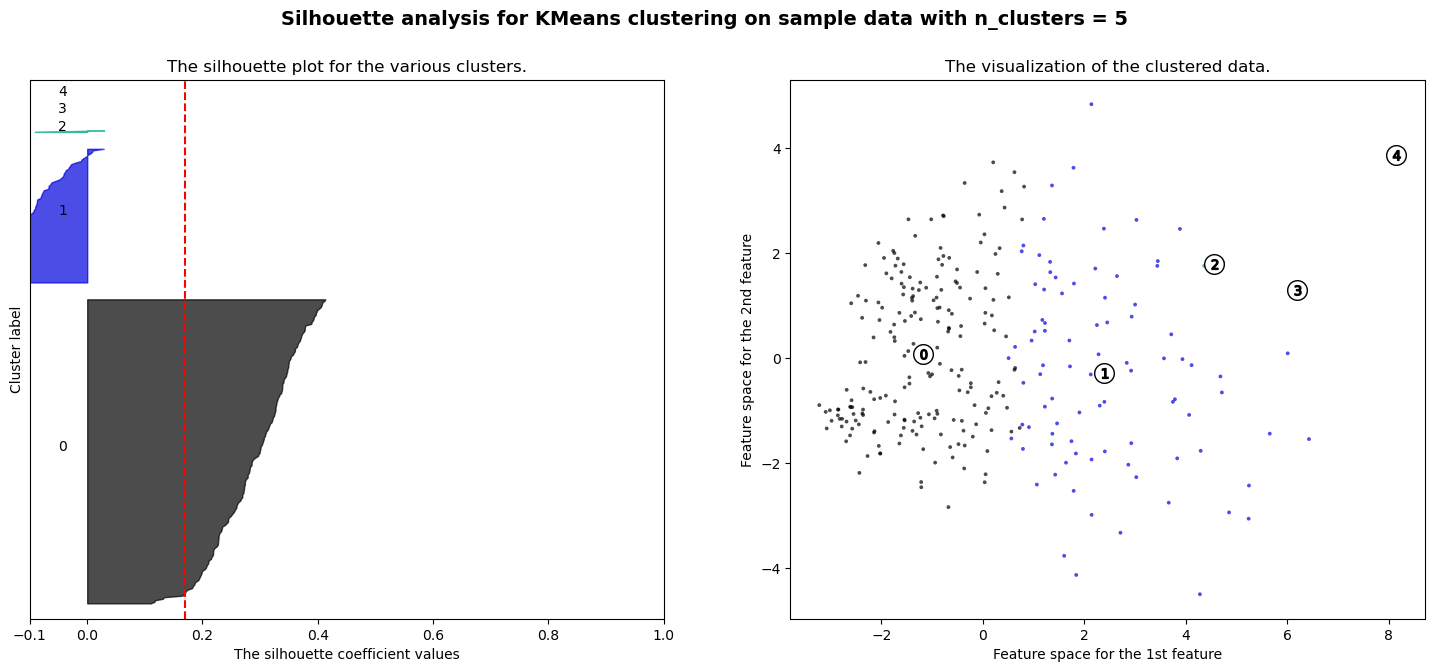

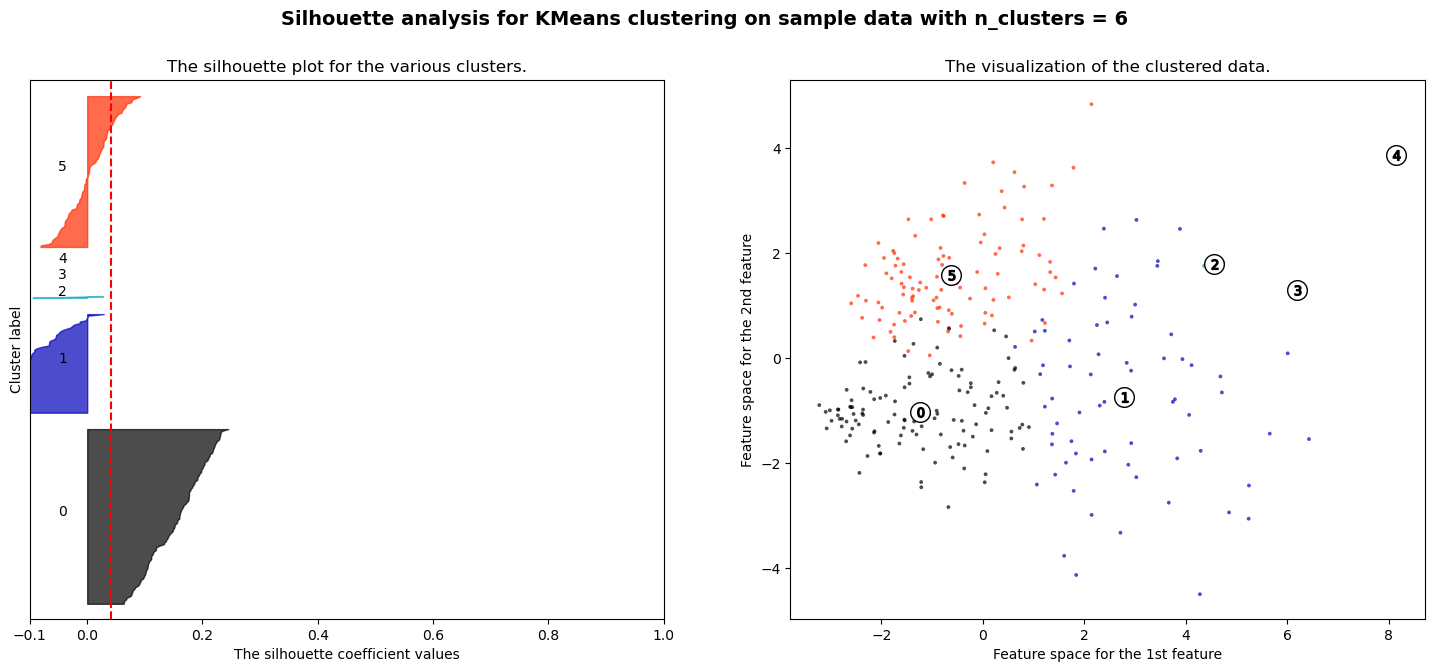

In [305]:
scaler = MinMaxScaler()
Y = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
pca.fit(Y)
X = pca.fit_transform(Y)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#### Data visualizations and normality tests

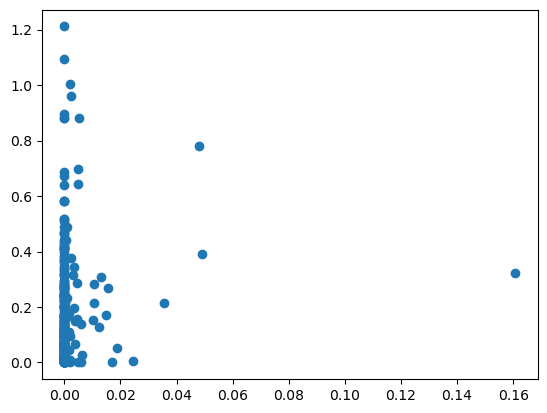

In [306]:
plt.scatter(fc1[:,1],fc1[:,0])
plt.show()

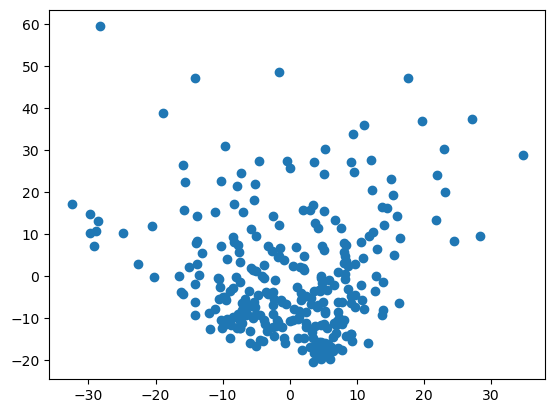

In [307]:
plt.scatter(reduced[:,1],reduced[:,0])
plt.show()

(107,)


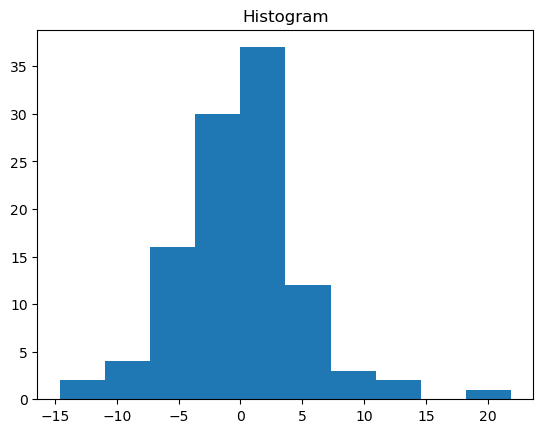

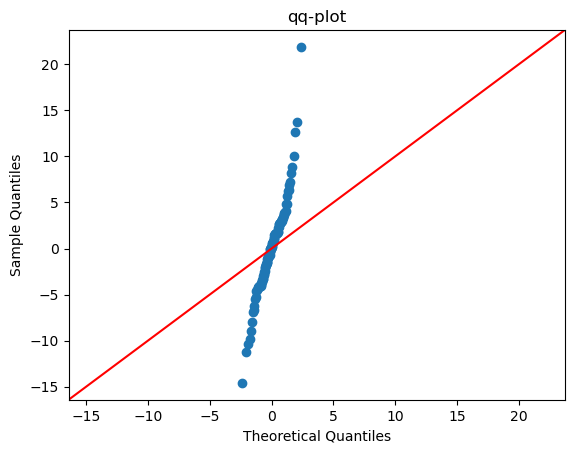

statistics=0.952, p=0.001
sample does not look gaussian
KstestResult(statistic=0.3466525911504956, pvalue=5.425557314093753e-12, statistic_location=1.5175625, statistic_sign=-1)
statistics=19.183, p=0.000
sample does not look gaussian
Statistic: 1.175
15.000: 0.556, data does not look normal (reject H0)
10.000: 0.634, data does not look normal (reject H0)
5.000: 0.760, data does not look normal (reject H0)
2.500: 0.887, data does not look normal (reject H0)
1.000: 1.055, data does not look normal (reject H0)


In [308]:
dataset = reduced[1]
#dataset = fc1

# data plots after pca
print(dataset.shape)
# histogram
plt.hist(dataset)
plt.title("Histogram")
plt.show()
# qq-plot
qq_plot = sm.qqplot(dataset, line='45')
plt.title("qq-plot")
plt.show()
# shapiro,wilk test
stat, p = shapiro(dataset)
print("statistics=%.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p > alpha:
    print("sample looks like gaussian")
else:
    print("sample does not look gaussian")
# kstest kolmogorov smirnov test
print(kstest(dataset, 'norm'))
# D'Agostinos K2 Test
stat, p = normaltest(dataset)
print("statistics=%.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p > alpha:
    print("sample looks like gaussian")
else:
    print("sample does not look gaussian")
# anderson darling test
result = anderson(dataset)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [309]:
print(pca.explained_variance_ratio_)

[0.11084541 0.06404685 0.0356301  0.02726425 0.02534211 0.02464841
 0.01773887 0.01735541 0.01595389 0.01559295 0.01459735 0.01378416
 0.01207598 0.01109815 0.01032375 0.01024815 0.00992138 0.00947339
 0.00945571 0.00896494 0.00848212 0.00821213 0.00770129 0.00752459
 0.00747637 0.00698365 0.00677282 0.00660481 0.00655177 0.0063813
 0.00616014 0.00592536 0.0059101  0.00582725 0.00566498 0.00559987
 0.00543515 0.00527671 0.00522813 0.00507462 0.00501335 0.00488986
 0.00486435 0.00478479 0.00473151 0.00466567 0.00447704 0.00440437
 0.00435996 0.00433282 0.00423865 0.00420676 0.00417716 0.00407066
 0.00404527 0.00401321 0.00389656 0.00383743 0.00378475 0.00372706
 0.00363998 0.00360047 0.00357002 0.00354204 0.0034866  0.00345021
 0.00336826 0.00334885 0.00329965 0.00323949 0.00320454 0.00318367
 0.00313813 0.0031003  0.00308267 0.00302833 0.00297541 0.00293159
 0.00292036 0.00288834 0.00285542 0.00282381 0.00279662 0.00275168
 0.00271769 0.00269983 0.00266442 0.00260828 0.00260395 0.00257